# `20180901a` - Trying a Kretz probe - process

In [11]:
#!/usr/bin/python
import spidev
import time
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import json
import time
from pyUn0 import *
%matplotlib inline
import os
from scipy.signal import hilbert, resample
import cv2

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Data acquired


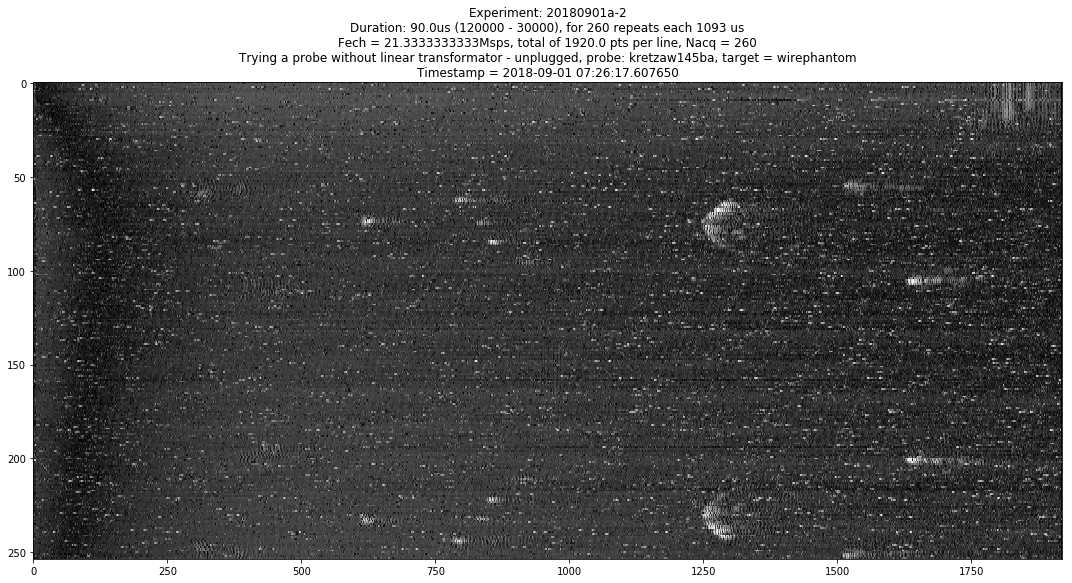

Data acquired


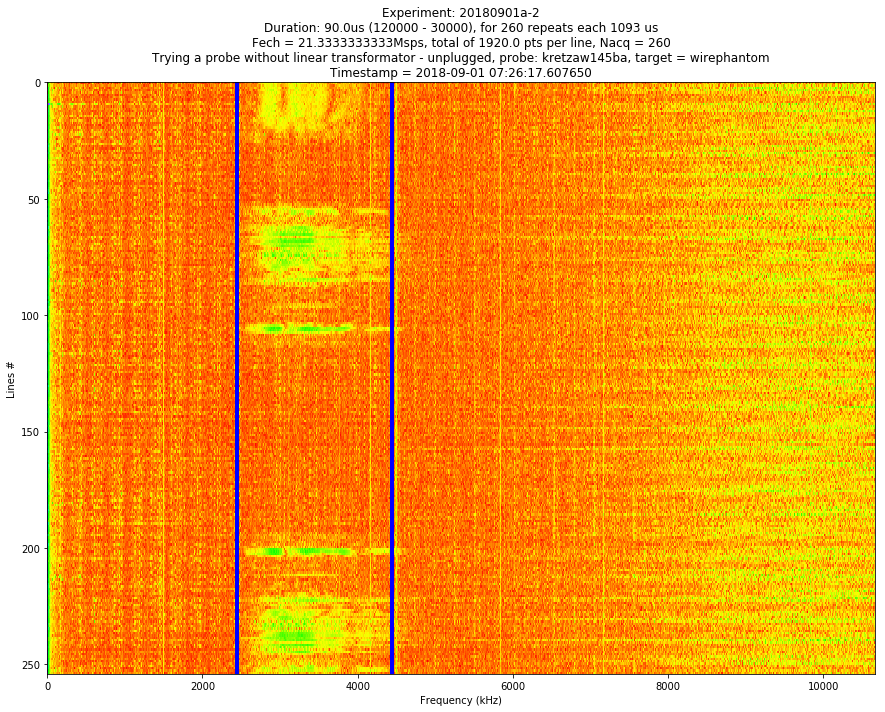

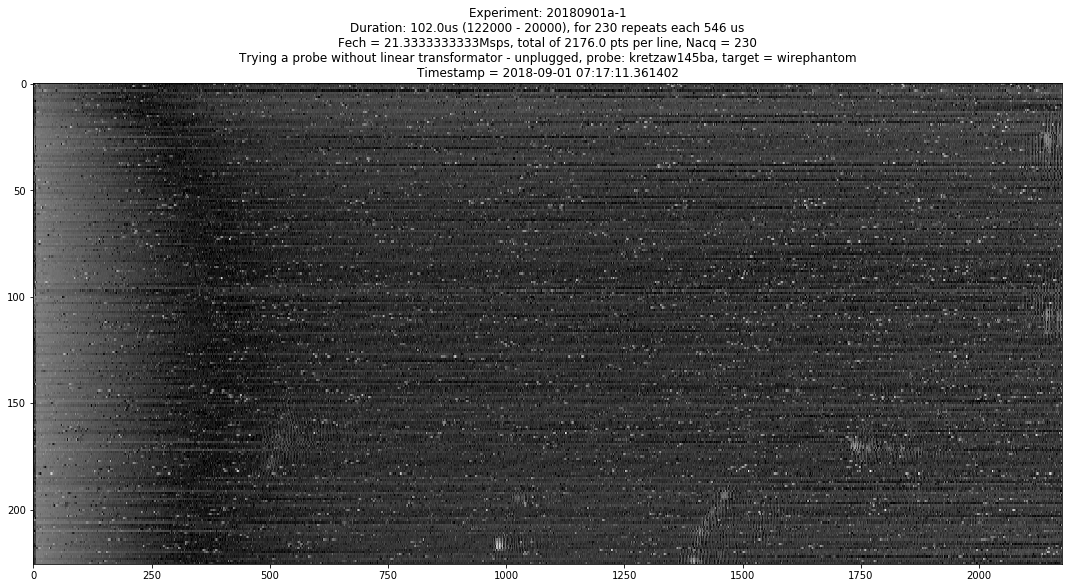

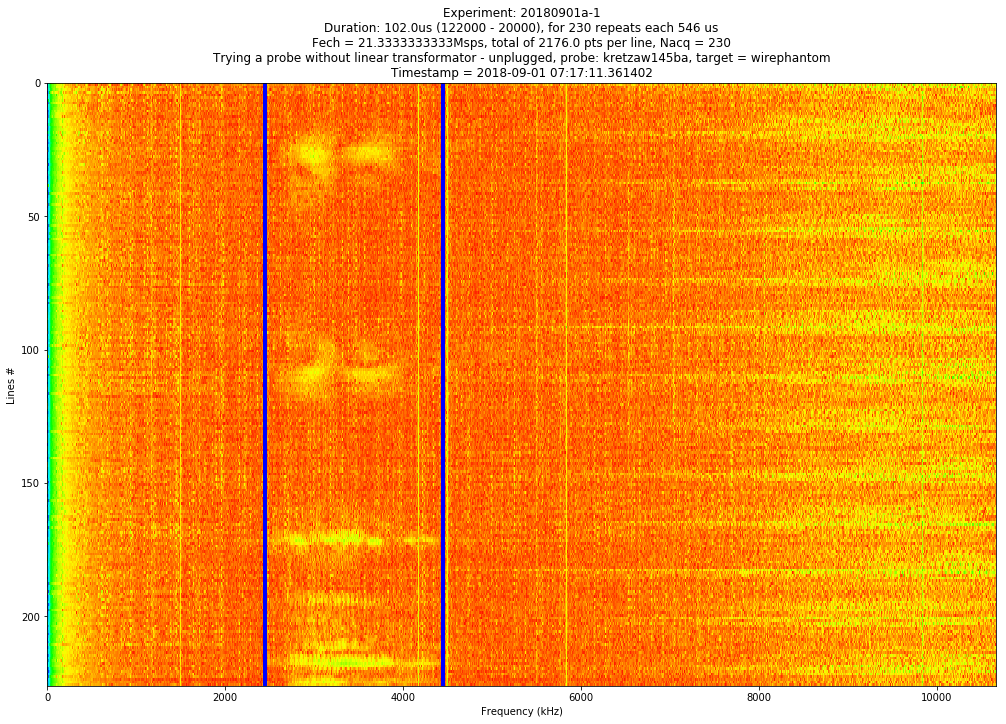

In [2]:
for MyDataFile in os.listdir("data/"):
    if MyDataFile.endswith(".json"):
        x = us_json()
        x.JSONprocessing("data/"+MyDataFile)
        CleanImage = x.mk2DArray()
        S = x.mkSpectrum(CleanImage)

20180901a-2.json
Data acquired


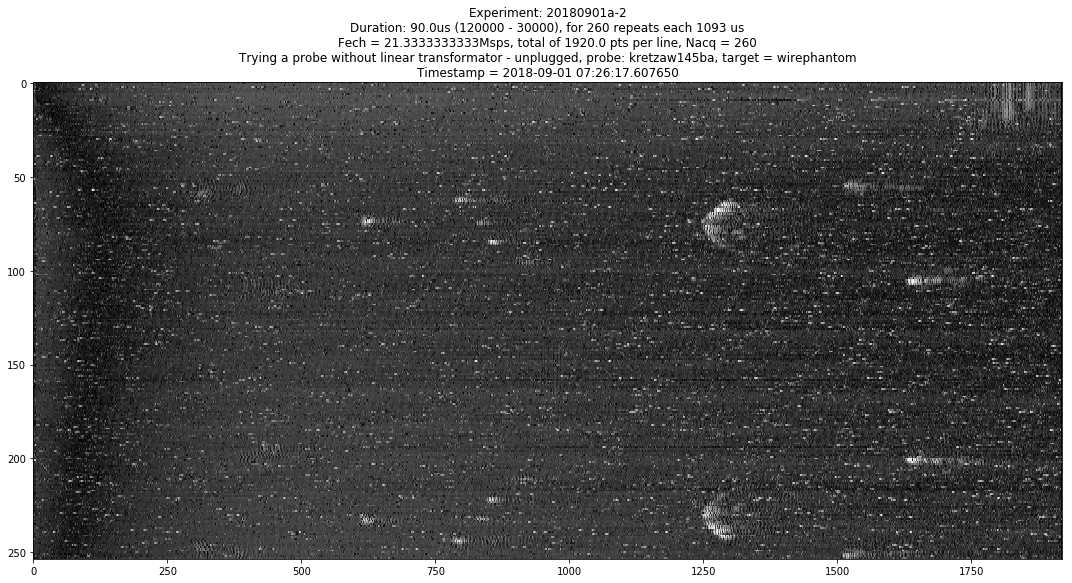

In [4]:
for MyDataFile in os.listdir("data/"):
    if MyDataFile.endswith("2.json"):
        print MyDataFile
        x = us_json()
        x.JSONprocessing("data/"+MyDataFile)
        CleanImage = x.mk2DArray()

# Building clean image

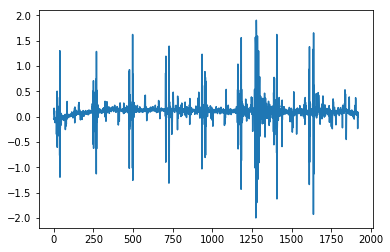

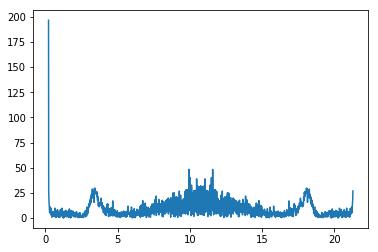

21.333333333333332

In [5]:
MV = np.argmax(np.var(CleanImage[:,20:-2], axis=1))

plt.plot(CleanImage[MV])
plt.show()
L = len(CleanImage[MV])
f = [k*x.f/L for k in range(L)]

plt.plot(f[20:-2], np.abs(np.fft.fft(CleanImage[MV][20:-2])))
plt.show()

x.f

In [6]:
N,L = np.shape(CleanImage)

In [7]:
#%%time
HMatrix = []
for m in range(N):
    line = CleanImage[m]
    L = len(line)
    A = np.fft.fft(line)
    for k in range (L/2 + 1):
        if k < (L * x.fPiezo * 0.7 / x.f):
            A[k] = 0
            A[-k] = 0
        if k > (L * x.fPiezo *1.3 / x.f):
            A[k] = 0
            A[-k] = 0

    CleanImage[m] =  np.real(np.fft.ifft(A))
    HMatrix.append(np.abs(hilbert(CleanImage[m])))

In [9]:
ProbeOffset = int(x.timings['t4'] *x.f / 1000)
ProbeOffset += int(5*1.3*x.f) # 5mm, 1.3us/mm, fech
CledImage = np.pad(CleanImage, ((0,0),(ProbeOffset,0)), 'constant')
HMatrixCld = np.pad(HMatrix, ((0,0),(ProbeOffset,0)), 'constant')
np.shape(HMatrix)

(254, 1920)

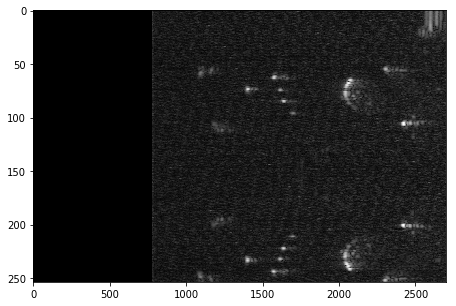

In [10]:
plt.figure(figsize = (15,5))
im = plt.imshow(np.sqrt(HMatrixCld), cmap='gray', aspect=1*(len(HMatrix[0])/len(HMatrix)), interpolation='nearest') 

# Scan conversion

In [12]:
n,l = np.shape(HMatrixCld)
print n,l

254 2698


In [18]:
im_in = np.asarray(HMatrixCld[0:150,:])

In [19]:
im_in.shape[0],im_in.shape[1]

(150, 2698)

maxRadius = 2698 pixels
95.4929658551 rows per radian
theta: [2.35619449019, 3.92699081699] radians
Padding 112 above and 112 below
CPU times: user 1.67 s, sys: 1.07 s, total: 2.74 s
Wall time: 1.73 s


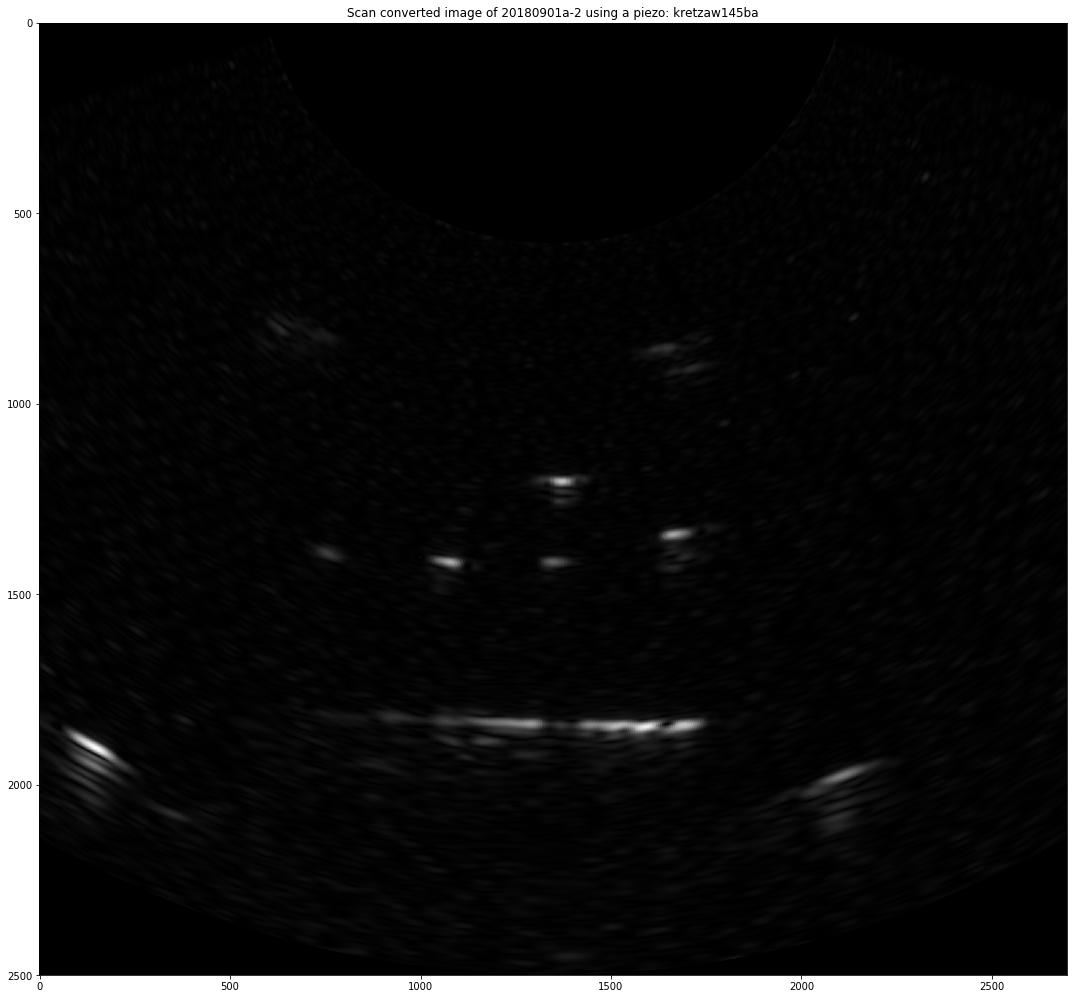

In [21]:
%%time

maxRadius = im_in.shape[1]
rows = im_in.shape[1]
print("maxRadius = {} pixels".format(maxRadius))

angle_range = np.pi/2 # range of angle swept by transducer (radians)
theta_scale_factor = im_in.shape[0] / angle_range # rows per radian
print("{} rows per radian".format(theta_scale_factor))
theta_min = 3/2*np.pi - angle_range/2
theta_max = 3/2*np.pi + angle_range/2
print("theta: [{}, {}] radians".format(theta_min, theta_max))

# pad the image
pad_below = int(0.5* theta_min * theta_scale_factor) # how many rows to pad below theta_min
pad_above = int(0.5* (2*np.pi - theta_max) * theta_scale_factor) # how mahy rows to pad above theta_max
print("Padding {} above and {} below".format(pad_above, pad_below))
im_below = np.zeros((pad_below, maxRadius), dtype='uint16')
im_above = np.zeros((pad_above, maxRadius), dtype='uint16')

padded_image = np.vstack((im_above, im_in, im_below))
# scale image
scaled_image = cv2.resize(padded_image, (2*maxRadius, maxRadius), interpolation=cv2.INTER_CUBIC)
#scaled_image = padded_image
# transform image
center = (rows, rows/2)
maxRadius = rows
flags = cv2.WARP_INVERSE_MAP
dst = cv2.linearPolar(scaled_image, center, maxRadius, flags)
plt.figure(figsize = (15,15))
Title = "Scan converted image of "+x.iD + "-"+ str(x.N)+" using a piezo: "+x.piezo
plt.title( Title )
plt.tight_layout()
FileName = "images/SC_"+x.iD+"-"+str(x.N)+"-fft.jpg"
plt.imshow(np.flipud(np.transpose((np.abs(dst)))[:2500,:]), cmap='gray')
plt.savefig(FileName)
TagImage(FileName,"matty,"+x.piezo,x.iD,"SC",Title)